# Training Your First Agent

Train a DQN agent on [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) and compare against simple baselines.

The pole starts upright and the agent must keep it balanced by pushing the cart left or right. An episode ends when the pole falls past a threshold angle or the cart leaves the track.

In [ ]:
import matplotlib.pyplot as plt

from myriad import create_config, create_eval_config, evaluate, train_and_evaluate
from myriad.envs import get_env_info
from myriad.utils.rendering import render_episode_to_video

from _helpers import side_by_side_videos

## Baselines

First, evaluate two non-learning controllers so we have reference scores for comparison.

The bang-bang controller switches on `theta_dot` (angular velocity) — pushing in the direction the pole is falling. This keeps the pole upright but ignores cart position, so the cart eventually drifts off the track. That limits it to ~185 out of a possible 500.

In [2]:
baselines = {
    "Random": dict(agent="random"),
    "Bang-Bang": dict(agent="bangbang", obs_field="theta_dot", threshold=0.0),
}

baseline_results = {}
for label, kwargs in baselines.items():
    config = create_eval_config(env="cartpole-control", eval_rollouts=50, seed=0, **kwargs)
    baseline_results[label] = evaluate(config)
    print(f"{label}: {baseline_results[label]}\n")

Random: EvaluationResults(
  mean_return=22.1 ± 10.9,
  range=[10.0, 57.0],
  mean_length=22.1,
  num_episodes=50
)

Bang-Bang: EvaluationResults(
  mean_return=184.5 ± 39.0,
  range=[131.0, 268.0],
  mean_length=184.5,
  num_episodes=50
)



## Train DQN

Configure and launch a DQN training run. Key settings:
- **128 parallel environments** for fast, stable data collection
- **5 000 steps per env** — enough for DQN to converge on CartPole
- **`epsilon_decay_steps=2000`** — linear exploration decay over 40% of training
- **`scan_chunk_size=500`** — must be &le; `eval_frequency` to avoid wasted computation

In [3]:
config = create_config(
    env="cartpole-control",
    agent="dqn",
    num_envs=128,
    steps_per_env=5000,
    eval_frequency=500,
    log_frequency=500,
    eval_rollouts=50,
    seed=0,
    epsilon_decay_steps=2000,
    target_network_frequency=100,
    scan_chunk_size=500,
)
results = train_and_evaluate(config)
print(results)

Training: 100%|██████████| 5000/5000 [00:01<00:00, 2676.41steps/s] , loss=0.064, eval_return=500.00

TrainingResults(
  final_eval_return=500.0 ± 0.0,
  steps_per_env=5,000,
  global_steps=640,000,
  num_evals=10
)


## Learning Curve

Plot DQN's mean return over training with baseline scores as horizontal reference lines.

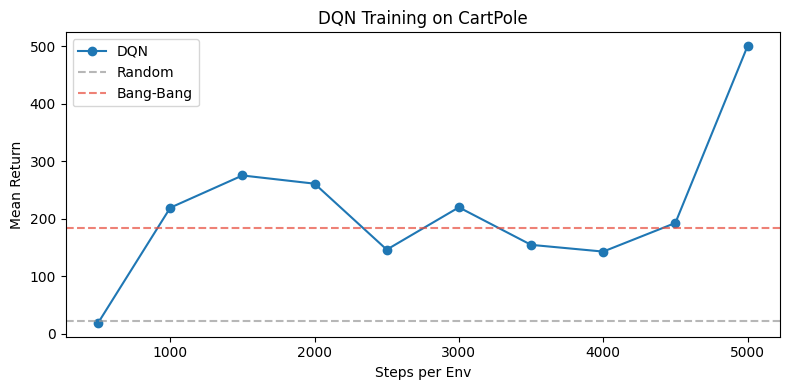

In [4]:
baseline_colors = {"Random": "#999", "Bang-Bang": "#e74c3c"}

plt.figure(figsize=(8, 4))
plt.plot(results.eval_metrics.steps_per_env, results.eval_metrics.mean_return, "o-", label="DQN")
for label, res in baseline_results.items():
    plt.axhline(y=res.mean_return, linestyle="--", color=baseline_colors[label], alpha=0.7, label=label)
plt.xlabel("Steps per Env")
plt.ylabel("Mean Return")
plt.legend()
plt.title("DQN Training on CartPole")
plt.tight_layout()
plt.show()

## Bang-Bang vs DQN

Render a single episode from each agent side by side. The bang-bang controller reacts to angular velocity alone, while the trained DQN has learned a policy over the full observation space.

In [5]:
render_fn = get_env_info("cartpole-control").render_frame_fn

agents_to_render = {
    "Bang-Bang": dict(agent="bangbang", obs_field="theta_dot", threshold=0.0),
    "DQN (trained)": dict(agent="dqn", agent_state=results.agent_state),
}

paths, labels = [], []
for label, kwargs in agents_to_render.items():
    agent_state = kwargs.pop("agent_state", None)
    config = create_eval_config(env="cartpole-control", eval_rollouts=1, seed=0, **kwargs)
    ep = evaluate(config, agent_state=agent_state, return_episodes=True)
    episode = {k: v[0] for k, v in ep.episodes.items()}

    path = render_episode_to_video(episode, render_fn, f"cartpole_{kwargs['agent']}.mp4", fps=50)
    paths.append(path)
    labels.append(label)

side_by_side_videos(paths, labels)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
